In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
from huggingface_hub import login
login()

In [2]:
from datasets import load_dataset
data=load_dataset("Amanaccessassist/playsent10m")
data

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/Amanaccessassist--playsent10m-c26cc28a2a046fb6/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['final_text', 'label'],
        num_rows: 644415
    })
    test: Dataset({
        features: ['final_text', 'label'],
        num_rows: 71602
    })
})

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(prompt):
    result = tokenizer(
        prompt['final_text'],
        truncation=True,
    )
    return result

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
from transformers import DataCollatorWithPadding
train_val = data["train"].train_test_split(
    test_size=0.1, shuffle=True, seed=42
)
train_data = (
    train_val["train"].map(tokenize)
)
val_data = (
    train_val["test"].map(tokenize)
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/579973 [00:00<?, ?ex/s]

  0%|          | 0/64442 [00:00<?, ?ex/s]

In [5]:
train_data.column_names

['final_text', 'label', 'input_ids', 'attention_mask']

In [7]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer,DataCollatorWithPadding
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
#model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, id2label=id2label, label2id=label2id).to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
!pip install bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for bitsandbytes from https://files.pythonhosted.org/packages/9b/63/489ef9cd7a33c1f08f1b2be51d1b511883c5e34591aaa9873b30021cd679/bitsandbytes-0.42.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 12.1 MB/s eta 0:00:0000:0100:01


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [13]:
from transformers import AdamW
from transformers import get_scheduler
import numpy as np
from datasets import load_metric
training_args = TrainingArguments(
    output_dir='emotion',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    max_steps=1000,
    warmup_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end = True,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    optim="adamw_8bit",
    seed=42

)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = val_data,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.232900,0.229911,0.921107,0.921358,0.921107,0.921097


TrainOutput(global_step=1000, training_loss=0.26639655661582945, metrics={'train_runtime': 1594.4072, 'train_samples_per_second': 80.281, 'train_steps_per_second': 0.627, 'total_flos': 5589761482241280.0, 'train_loss': 0.26639655661582945, 'epoch': 0.22})

In [14]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.22991116344928741,
 'eval_accuracy': 0.9211073523478477,
 'eval_precision': 0.9213582014463746,
 'eval_recall': 0.9211073523478477,
 'eval_f1': 0.9210970707304227,
 'eval_runtime': 238.5409,
 'eval_samples_per_second': 270.151,
 'eval_steps_per_second': 8.443,
 'epoch': 0.22}

In [12]:
import os
from huggingface_hub import login
login()

In [16]:
model.save_pretrained("robertas_model")
model.push_to_hub("Amanaccessassist/DistilledSent10m")
tokenizer.push_to_hub("Amanaccessassist/DistilledSent10m")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Amanaccessassist/DistilledSent10m/commit/3478174882e19147e793ac35d2fec62284857368', commit_message='Upload tokenizer', commit_description='', oid='3478174882e19147e793ac35d2fec62284857368', pr_url=None, pr_revision=None, pr_num=None)

In [41]:
preds_output = trainer.predict(val_data)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize = "true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                 display_labels=labels)
    disp.plot(cmap="Blues", values_format = ".2f", ax = ax,
             colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [46]:
y_valid = np.array(val_data["label"])
labels = train_data.features["label"]

TypeError: unsupported format string passed to Value.__format__

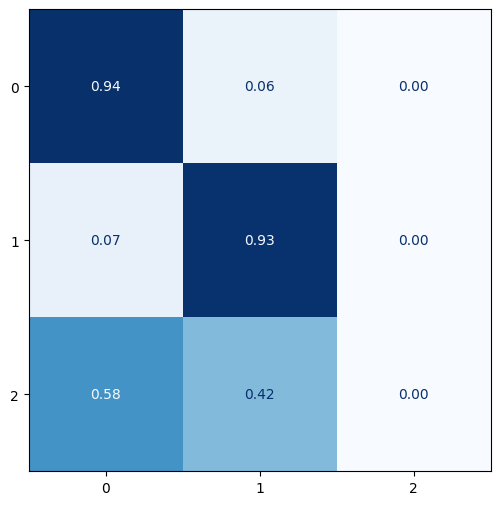

In [48]:
import matplotlib.pyplot as plt
plot_confusion_matrix(y_preds, y_valid, labels)

In [16]:
from transformers import pipeline
pipe = pipeline("text-classification", model="Amanaccessassist/RobertaPlaysent")
result =pipe("chutiyaa app")
label_mapping = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Positive'
}
result = label_mapping[result[0]['label']]
print(result)

In [17]:
result

'Negative'